# **Feature Engineering**

## Objectives

* Create new features to improve model predictions.
* Transform and combine existing features.
* Explore the relationships between features and the target variable.

## Inputs

* Cleaned dataset: `outputs/datasets/collection/HousePricesRecords.csv`
* Data with handled missing values and correct data types.

## Outputs

* New dataset with engineered features: `outputs/datasets/feature_engineered/HousePricesFeatures.csv`
* Visualizations (if applicable): Charts showing feature relationships and distributions.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

## Load data

In [50]:
import pandas as pd
df = pd.read_csv("../jupyter_notebooks/outputs/datasets/collection/HousePricesRecords.csv")

df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856.0,854.0,3.0,No,706.0,GLQ,150.0,0.0,548.0,RFn,...,65.0,196.0,61.0,5,7,856.0,0.0,2003,2003,208500.0
1,1262.0,0.0,3.0,Gd,978.0,ALQ,284.0,NaN,460.0,RFn,...,80.0,0.0,0.0,8,6,1262.0,NaN,1976,1976,181500.0
2,920.0,866.0,3.0,Mn,486.0,GLQ,434.0,0.0,608.0,RFn,...,68.0,162.0,42.0,5,7,920.0,NaN,2001,2002,223500.0
3,961.0,NaN,NaN,No,216.0,ALQ,540.0,NaN,642.0,Unf,...,60.0,0.0,35.0,5,7,756.0,NaN,1915,1970,140000.0
4,1145.0,NaN,4.0,Av,655.0,GLQ,490.0,0.0,836.0,RFn,...,84.0,350.0,84.0,5,8,1145.0,NaN,2000,2000,250000.0


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.imputation import MeanMedianImputer

# Custom encoder for categorical variables
class MyCustomEncoder(BaseEstimator, TransformerMixin):
    """
    Custom transformer to encode categorical variables 
    using a predefined mapping dictionary.
    """
    def __init__(self, variables, mapping):
        self.variables = variables  # List of variables to encode
        self.mapping = mapping      # Dictionary containing mapping for each variable

    def fit(self, X, y=None):
        # No fitting is required for this transformer
        return self

    def transform(self, X):
        # Apply the mappings to the specified variables
        X = X.copy()
        for feature in self.variables:
            if feature in X.columns:  # Check if the feature exists in the DataFrame
                X[feature] = X[feature].map(self.mapping.get(feature, {}))
        return X

# Define the mapping for categorical variables
mapping = {
    'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0},
    'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
}

# Specify columns with missing data for median imputation
vars_with_missing_data = [
    '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinType1', 
    'GarageFinish', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea'
]

# Create the pipeline
pipeline = Pipeline([
    # Encode categorical variables using MyCustomEncoder
    ('custom_encoder', MyCustomEncoder(variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'], mapping=mapping)),
    
    # Impute missing values with the median
    ('median_imputer', MeanMedianImputer(imputation_method='median', variables=vars_with_missing_data)),
    
    # Automatically drop highly correlated features
    ('corr_selector', SmartCorrelatedSelection(method="spearman", threshold=0.8, selection_method="variance"))
])

# Remove the target variable before applying the pipeline
df_without_target = df.drop(columns=['SalePrice'], errors='ignore')

# Apply the pipeline to the dataset
df_transformed = pipeline.fit_transform(df_without_target)

# Add the target variable back to the transformed dataset
df_transformed['SalePrice'] = df['SalePrice']

# Display results
print("Transformed DataFrame:")
print(df_transformed.head())


Add total area and create basement indicator variable

In [51]:
df['TotalArea'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['GrLivArea']
df['HasBasement'] = df['BsmtExposure'].apply(lambda x: 1 if x != 'No' else 0)
print("Added 'TotalArea' and 'HasBasement' features.")

Added 'TotalArea' and 'HasBasement' features.


In [52]:
print("DataFrame shape after operation:", df.shape)
print("DataFrame columns after operation:", df.columns.tolist())


DataFrame shape after operation: (1460, 26)
DataFrame columns after operation: ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice', 'TotalArea', 'HasBasement']


Show correlation matrix for numeric features

In [53]:
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()


Install seaborn

In [54]:
!pip install seaborn

Convert text columns to numbers using category encoding

In [55]:
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    df[column] = df[column].astype('category').cat.codes
print(f"Encoded {len(categorical_columns)} categorical columns.")

Encoded 4 categorical columns.


Create a heatmap to visualize the correlation matrix

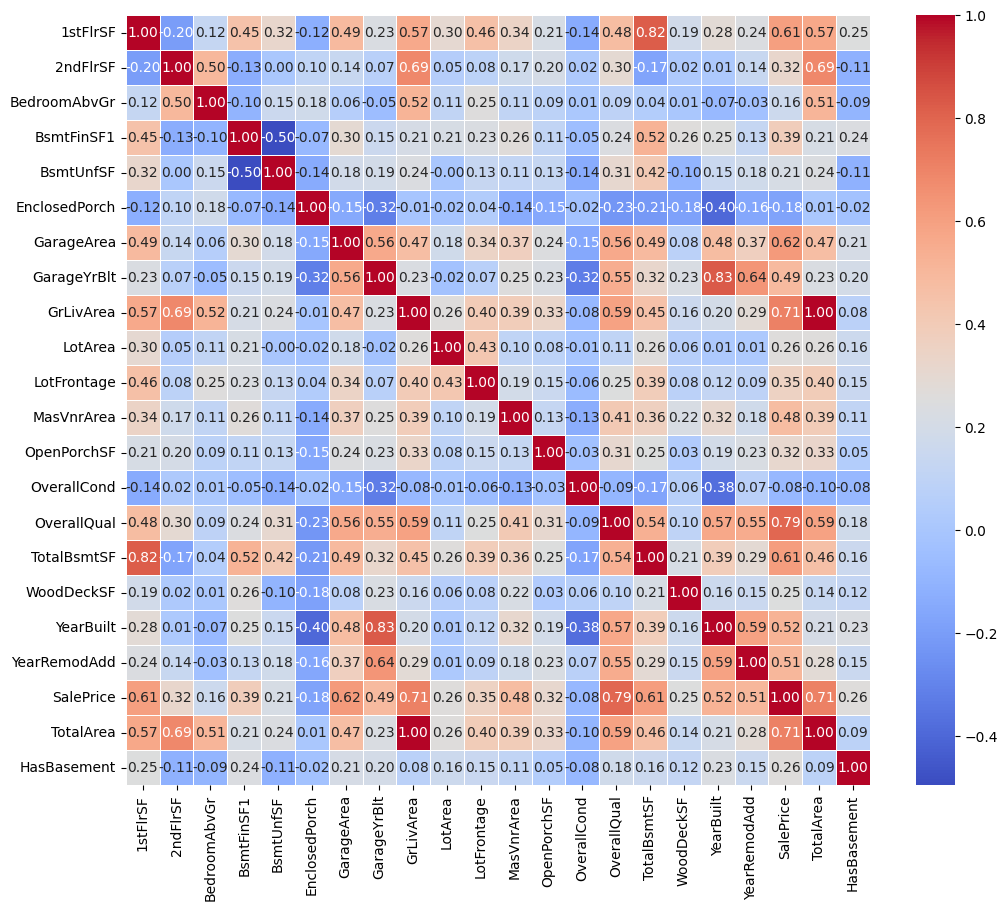

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()


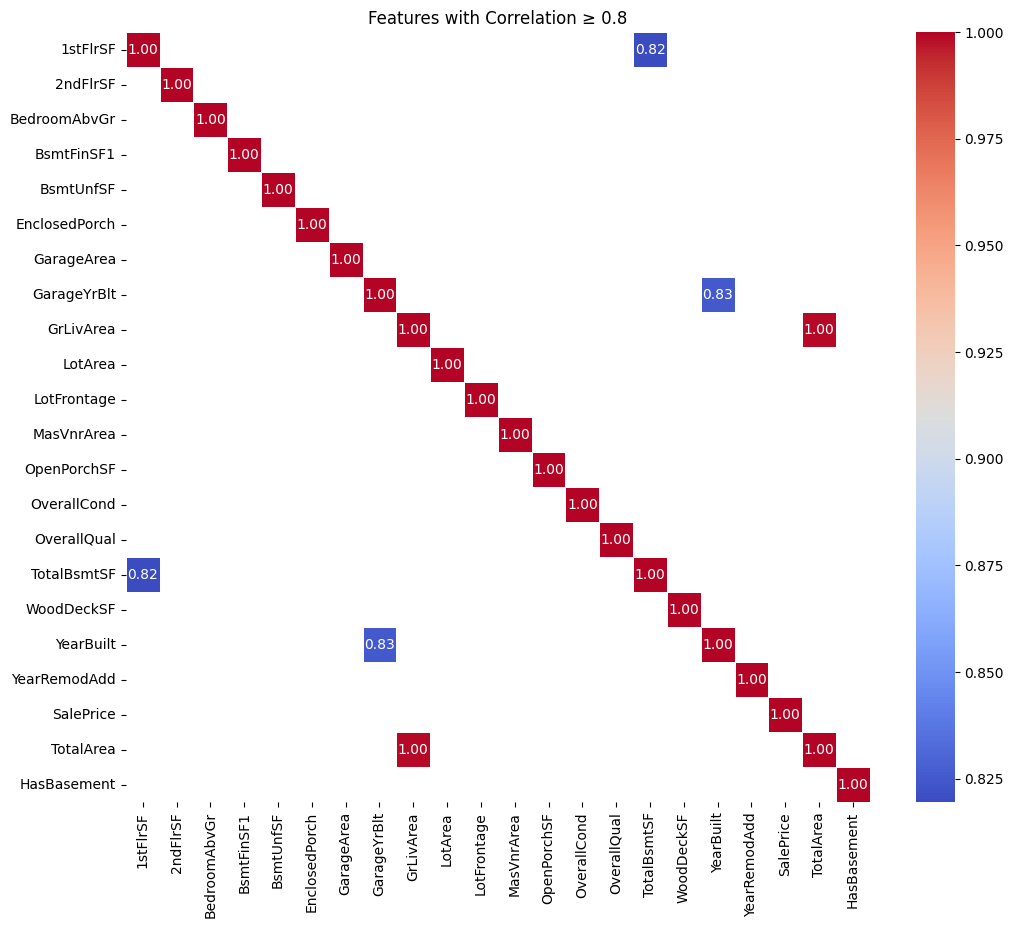

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Threshold for high correlation
threshold = 0.8

# Filter correlation matrix to keep values >= 0.8
high_correlation = correlation_matrix.applymap(lambda x: x if x >= threshold else np.nan)

# Plot the filtered correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(high_correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Features with Correlation ≥ 0.8")
plt.show()


Remove columns with correlation above the threshold (0.8)

In [58]:
import pandas as pd

# Set a threshold for correlation
threshold = 0.8

# Identify columns to drop, excluding the target variable and avoiding self-correlation
to_drop = [
    column
    for column in correlation_matrix.columns
    if any(correlation_matrix[column].drop(index=column).drop(labels=['SalePrice'], errors='ignore') > threshold)
]

# Filter out columns that no longer exist in DataFrame
to_drop = [col for col in to_drop if col in df.columns]

# Drop the selected columns
df.drop(columns=to_drop, inplace=True)

# Print results
print("Removed columns:", to_drop)
print("Remaining columns:", df.columns.tolist())


Removed columns: ['1stFlrSF', 'GarageYrBlt', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'TotalArea']
Remaining columns: ['2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageFinish', 'KitchenQual', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'WoodDeckSF', 'YearRemodAdd', 'SalePrice', 'HasBasement']


Install scitik learn

In [11]:
!pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 175.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 119.2 MB/s eta 0:00:0000:01


Scale numerical features to standardize their values

In [63]:
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import SmartCorrelatedSelection

# Define columns to scale (remove 'GrLivArea' as it was already dropped)
expected_columns = ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea']

# Ensure the expected columns exist in the DataFrame
missing_columns = [col for col in expected_columns if col not in df.columns]
if missing_columns:
    raise KeyError(f"The following columns are missing from the DataFrame: {missing_columns}")

# Scale numerical features
scaler = StandardScaler()
df[expected_columns] = scaler.fit_transform(df[expected_columns])
print("Scaled columns successfully!")

# SmartCorrelatedSelection
corr_selector = SmartCorrelatedSelection(method="spearman", threshold=0.8, selection_method="variance")

# Remove the target variable from the dataset
X = df.drop(columns=['SalePrice'])

# Apply SmartCorrelatedSelection to the dataset
X_transformed = corr_selector.fit_transform(X)

# Update the dataset
df = X_transformed.copy()
df['SalePrice'] = df['SalePrice'] if 'SalePrice' in df else None  # Add the target variable back

# Display results
print("Remaining columns after SmartCorrelatedSelection:")
print(df.columns.tolist())
print("Removed features:", corr_selector.features_to_drop_)
print("Correlated feature groups:", corr_selector.correlated_feature_sets_)




Scaled columns successfully!
Remaining columns after SmartCorrelatedSelection:
['2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageFinish', 'KitchenQual', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'WoodDeckSF', 'YearRemodAdd', 'SalePrice']
Removed features: ['HasBasement']
Correlated feature groups: [{'HasBasement', 'BsmtExposure'}]


Show datatypes

In [65]:
print(df.dtypes)


2ndFlrSF         float64
BedroomAbvGr     float64
BsmtExposure        int8
BsmtFinSF1       float64
BsmtFinType1        int8
BsmtUnfSF        float64
EnclosedPorch    float64
GarageArea       float64
GarageFinish        int8
KitchenQual         int8
LotArea          float64
LotFrontage      float64
MasVnrArea       float64
OpenPorchSF      float64
OverallCond        int64
OverallQual        int64
WoodDeckSF       float64
YearRemodAdd       int64
SalePrice         object
dtype: object


Convert categorical columns to categories and apply One-Hot Encoding

In [66]:
categorical_columns = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
print(f"Applied One-Hot Encoding to: {categorical_columns}")

Applied One-Hot Encoding to: ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']


Print the number of unique values in each column

In [67]:
print(df.nunique())


2ndFlrSF           401
BedroomAbvGr         8
BsmtFinSF1         637
BsmtUnfSF          780
EnclosedPorch       19
GarageArea         441
LotArea           1073
LotFrontage        110
MasVnrArea         327
OpenPorchSF        202
OverallCond          9
OverallQual         10
WoodDeckSF          58
YearRemodAdd        61
SalePrice            0
BsmtExposure_0       2
BsmtExposure_1       2
BsmtExposure_2       2
BsmtExposure_3       2
BsmtFinType1_0       2
BsmtFinType1_1       2
BsmtFinType1_2       2
BsmtFinType1_3       2
BsmtFinType1_4       2
BsmtFinType1_5       2
GarageFinish_0       2
GarageFinish_1       2
GarageFinish_2       2
KitchenQual_1        2
KitchenQual_2        2
KitchenQual_3        2
dtype: int64


In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import SmartCorrelatedSelection

#  Define the pipeline
pipeline = Pipeline([
    # Scaling numerical features
    ('scaler', StandardScaler()),

    # Automatically handle correlations using SmartCorrelatedSelection
    ('correlation_selector', SmartCorrelatedSelection(
        method="spearman",
        threshold=0.8,
        selection_method="variance"
    ))
])

# Define numerical columns to scale
numerical_columns = ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea', 'GrLivArea']

# Filter columns to ensure they exist in the current dataset
columns_to_scale = [col for col in numerical_columns if col in df.columns]

# Exclude the target variable (SalePrice) and apply the pipeline
X = df[columns_to_scale]
X_transformed = pipeline.fit_transform(X)

# Recreate the DataFrame with processed numerical features
df_transformed = pd.DataFrame(X_transformed, columns=columns_to_scale)

# Add the target variable back to the transformed DataFrame
df_transformed['SalePrice'] = df['SalePrice']

# Display results
print(f"Pipeline completed: {df_transformed.columns.tolist()}")



Pipeline completed: ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea', 'SalePrice']


Split data into training and test sets (70% training, 30% test)

In [74]:
from sklearn.model_selection import train_test_split

X = df.drop('SalePrice', axis=1)
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Training set: (1022, 30), Test set: (438, 30)


Fill missing values, train model, and evaluate performance

___

## Push files to repo